In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.axis import Axis
import datetime as dt

import time
start = time.time()

In [2]:
def get_data2(filename):    
    data = pd.read_csv(filename) #, names=["Interval","kWh"])
    return data

In [3]:
def conso_byhour(day):
    ''' 
    display conso by hour for the chosen day
    '''
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))

    conso_hours = conso_day.copy()
    conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
    conso_hours#.info()
    # group by hour
    groupedbyhour = conso_hours[['hours','kWh']].groupby('hours', sort=False)
    groupedbyhour.count()
    len(groupedbyhour)
    x = np.arange(1,len(groupedbyhour)+1)

    #groupedbyhour.count().plot(grid=True,xticks=x)
    plt.figure(figsize=(12, 8),facecolor='darkcyan')
    values = groupedbyhour.count().kWh
    #ax = plt.bar(x,groupedbyhour.count().kWh)
    ax = values.plot(kind="bar",color='green',width=.8)
    ax.set_facecolor('antiquewhite')
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) - {day}')
    plt.xlim(-1,len(x)+1)
    plt.xticks(rotation=30);
    
    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in values]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom",
            fontfamily='calibri', fontsize=16, fontweight='bold', color='blue'
        )
    
    
def from_csv(csv_file): 
    ''' save data to csv  '''
    df = pd.read_csv(csv_file)
    return df
    
def to_csv(csv_file, df):
    ''' read data from csv'''
    df.to_csv(csv_file, index=False)

def period(p=1):
    ''' 
    give the time of conso for a 1kWh window in a day
    p =  ordinal window ex: p=1 first kWh, p=2 second kWh ..
    df is the data from midnight, each entry is 1 watt
    as the length of df is the total conso in watt,
    we have len(df)/1000 = number of windows of 1 KWh since midnight
    the last window may not be 1000 watt long !
    '''
    if p==1:
        start = df.iloc[0].dates
    else:
        start = df.iloc[(p-1)*1000-1].dates
    if len(df)>p*1000:
        end = df.iloc[p*1000-1].dates
        conso = p*1000
    else:
        end = df.iloc[len(df)-1].dates
        conso = len(df) - (p-1)*1000
    period = end - start  # type timedelta
    hours = int(period / dt.timedelta(hours=1))
    mins = int(period / dt.timedelta(minutes=1)) - hours*60
    secs = int(period / dt.timedelta(seconds=1)) - hours*3600 - mins*60

    #df.iloc[1001:2000]['dates']#.tail(1)
    #print(period)
    print(f'{start}\t{end}\t{hours}h {mins}m {secs}s \t{conso}')


### conso.csv créé par pi4 node-red onglet Linky

In [4]:
conso_file = r"\\192.168.0.175\pihome\Documents\conso2.csv"
conso_data = get_data2(conso_file)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1946349 entries, 0 to 1946348
Data columns (total 2 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Interval  int64  
 1   kWh       float64
dtypes: float64(1), int64(1)
memory usage: 29.7 MB


In [5]:
conso_data['kWh']

0          0.16
1          0.16
2          0.16
3          0.16
4          0.16
           ... 
1946344    0.24
1946345    0.24
1946346    0.24
1946347    0.24
1946348    0.24
Name: kWh, Length: 1946349, dtype: float64

In [6]:
conso_data['kWh']

0          0.16
1          0.16
2          0.16
3          0.16
4          0.16
           ... 
1946344    0.24
1946345    0.24
1946346    0.24
1946347    0.24
1946348    0.24
Name: kWh, Length: 1946349, dtype: float64

In [7]:
l=len(conso_data)-1
l

1946348

In [8]:
conso_data['sec']=conso_data['Interval']/1000


In [9]:
conso_data['Wh']=3600000/conso_data['Interval']


In [10]:
conso_data['cumul(ms)']=conso_data['Interval'].cumsum(axis=0)

In [11]:
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1946349 entries, 0 to 1946348
Data columns (total 5 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Interval   int64  
 1   kWh        float64
 2   sec        float64
 3   Wh         float64
 4   cumul(ms)  int64  
dtypes: float64(3), int64(2)
memory usage: 74.2 MB


In [12]:
conso_data.tail()

,Interval,kWh,sec,Wh,cumul(ms)
1946344,14977,0.24,14.977,240.368565,47691195836
1946345,14995,0.24,14.995,240.080027,47691210831
1946346,14718,0.24,14.718,244.598451,47691225549
1946347,14893,0.24,14.893,241.724300,47691240442
1946348,14965,0.24,14.965,240.561310,47691255407


In [13]:
cumtime= int(conso_data._get_value(l,'cumul(ms)')*1000)  # convert to microseconds
cumtime

47691255407000

In [14]:
from datetime import datetime, timedelta
now = datetime.now()
# conso.csv dynamique
base = now - timedelta(microseconds=cumtime)
base  # date de début

datetime.datetime(2023, 8, 21, 21, 16, 13, 706631)

In [15]:
conso_data['cumul(ms)'][conso_data['cumul(ms)'].isna()==True]

Series([], Name: cumul(ms), dtype: int64)

In [16]:
conso_data.iloc[0]


Interval     21934.00000
kWh              0.16000
sec             21.93400
Wh             164.12875
cumul(ms)    21934.00000
Name: 0, dtype: float64

# Recréer les dates à partir des cumuls par impulsion


In [17]:
base

datetime.datetime(2023, 8, 21, 21, 16, 13, 706631)

In [18]:
# create column 'dates' with time cumulated time from base
conso_data['dates'] = [base + dt.timedelta(microseconds=t*1000) for t in conso_data['cumul(ms)']]
conso_data['dates']

0         2023-08-21 21:16:35.640631
1         2023-08-21 21:16:57.498631
2         2023-08-21 21:17:19.499631
3         2023-08-21 21:17:41.427631
4         2023-08-21 21:18:03.318631
                     ...            
1946344   2025-02-23 20:49:29.542631
1946345   2025-02-23 20:49:44.537631
1946346   2025-02-23 20:49:59.255631
1946347   2025-02-23 20:50:14.148631
1946348   2025-02-23 20:50:29.113631
Name: dates, Length: 1946349, dtype: datetime64[ns]

## créer les dates

In [19]:
# create column 'days' avec format 'dd/mm/yy'
conso_data['days']= [d.strftime('%d/%m/%y') for d in conso_data['dates']]    
#[str(d.month)+'-'+str(d.day) for d in conso_data['dates']]
conso_data

,Interval,kWh,sec,Wh,cumul(ms),dates,days
0,21934,0.16,21.934,164.128750,21934,2023-08-21 21:16:35.640631,21/08/23
1,21858,0.16,21.858,164.699424,43792,2023-08-21 21:16:57.498631,21/08/23
2,22001,0.16,22.001,163.628926,65793,2023-08-21 21:17:19.499631,21/08/23
3,21928,0.16,21.928,164.173659,87721,2023-08-21 21:17:41.427631,21/08/23
4,21891,0.16,21.891,164.451144,109612,2023-08-21 21:18:03.318631,21/08/23
...,...,...,...,...,...,...,...
1946344,14977,0.24,14.977,240.368565,47691195836,2025-02-23 20:49:29.542631,23/02/25
1946345,14995,0.24,14.995,240.080027,47691210831,2025-02-23 20:49:44.537631,23/02/25
1946346,14718,0.24,14.718,244.598451,47691225549,2025-02-23 20:49:59.255631,23/02/25
1946347,14893,0.24,14.893,241.724300,47691240442,2025-02-23 20:50:14.148631,23/02/25


### save conso_data with dates

In [20]:
#to_csv(r'../conso_data_with_dates.csv',conso_data)

# tranche journalière


In [21]:
now = datetime.now()
month = now.month
year = now.year
date = now.day
today = now.strftime('%d/%m/%y')    #str(now.month)+'-'+str(now.day)
today, date, month, year


('23/02/25', 23, 2, 2025)

In [22]:
here = now.strftime('%H:%M:%S')
here

'20:50:59'

In [23]:
conso_day = conso_data[conso_data['days']==today]
# save to file
filename='conso_jour.csv'
conso_day.to_csv(filename)
filename='../conso_jour.csv'
conso_day.to_csv(filename)

In [24]:
conso_day.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3964 entries, 1942385 to 1946348
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   3964 non-null   int64         
 1   kWh        3964 non-null   float64       
 2   sec        3964 non-null   float64       
 3   Wh         3964 non-null   float64       
 4   cumul(ms)  3964 non-null   int64         
 5   dates      3964 non-null   datetime64[ns]
 6   days       3964 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 247.8+ KB


In [25]:
# group by day
grouped = conso_data[['days','kWh']].groupby('days', sort=False)
'''conso_graph=[]
for name, group in grouped:
    if name=='01/04/2024':print(group)
    #print("\n", name, len(group)/1000)
    conso_graph.append((name,len(group)/1000))'''
#grouped
# count elements in each group => conso in watts => convert to kW
df_grp = grouped.count()/1000



In [26]:
data = list(df_grp['kWh'])
print(data)

[0.554, 3.701, 4.227, 3.686, 3.949, 4.587, 3.736, 3.467, 3.5, 3.706, 3.411, 4.151, 4.228, 3.665, 3.631, 3.639, 3.317, 3.375, 4.059, 4.033, 4.013, 4.104, 3.509, 4.24, 3.968, 3.748, 4.093, 4.62, 4.144, 3.222, 3.171, 3.869, 3.806, 3.077, 3.784, 4.167, 3.612, 3.729, 4.564, 4.315, 4.419, 3.905, 3.445, 4.265, 3.922, 3.77, 3.542, 3.947, 3.769, 3.457, 4.121, 3.388, 3.826, 3.89, 3.594, 3.74, 4.323, 3.255, 3.868, 3.168, 2.06, 2.042, 2.286, 4.088, 3.637, 4.308, 3.63, 3.989, 3.777, 3.693, 4.211, 3.964, 3.803, 3.128, 3.76, 3.584, 3.551, 3.713, 3.674, 3.34, 3.808, 3.252, 3.757, 3.6, 4.058, 3.566, 3.545, 3.67, 4.043, 4.404, 3.927, 4.066, 4.347, 3.825, 3.868, 3.828, 3.788, 3.823, 4.08, 4.41, 3.873, 3.502, 3.677, 3.68, 3.347, 3.831, 3.799, 4.309, 3.528, 4.163, 3.536, 3.943, 4.691, 3.592, 3.585, 3.52, 3.961, 3.866, 4.15, 3.854, 3.835, 3.627, 5.033, 3.79, 3.676, 4.218, 4.262, 4.345, 4.522, 4.146, 3.658, 4.462, 4.707, 4.096, 4.754, 4.495, 3.66, 4.04, 3.913, 3.617, 3.566, 3.955, 3.66, 3.723, 3.626, 3.494, 

In [27]:
# save to file
import pickle
path = r'kwh_mean.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

In [28]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
def show(day,pltcolor='darkcyan',bgcolor="ivory"):
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))
    #=[x.hour for x in conso_day['dates']]
    df = conso_day.set_index('heure')
    here = now.strftime('%H:%M:%S')
    conso_jour=len(df['kWh'])
    here, len(df)/1000, conso_jour

    # consommation d'une journée entière à partir de minuit
    # Set background color of the outer 
    # area of the plt
    #plt.figure(facecolor=fgcolor)
    fig, ax = plt.subplots(facecolor=pltcolor)
    
    major_ticks=300;minor_ticks=100
    ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  # major ticks tous les 15 min
    ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
    # the size of A4 paper
    fig.set_size_inches(10, 5)
    
    # set bg color
    ax.set_facecolor(bgcolor)
    plt.plot(df['kWh'])
    #plt.plot(conso_day['heure'],conso_day['kWh'])
    plt.title(f'Journée du {day} {here} : {conso_jour/1000} kwh')
    plt.grid()
    plt.xticks(rotation=30);


In [29]:
df = conso_data
len(df)

1946349

In [30]:
period(p=2)

2023-08-22 03:22:49.443631	2023-08-22 10:27:05.063631	7h 4m 15s 	2000


In [31]:
# mean of all instant conso
total_mean = conso_data[['kWh']].mean()
total_mean

kWh    0.300541
dtype: float64

In [32]:
mean=(grouped.count()/1000).mean()
mean

kWh    3.519618
dtype: float64

In [33]:
last=df_grp.iloc[-1]['kWh']
last

3.964

In [34]:
conso_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3964 entries, 1942385 to 1946348
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   3964 non-null   int64         
 1   kWh        3964 non-null   float64       
 2   sec        3964 non-null   float64       
 3   Wh         3964 non-null   float64       
 4   cumul(ms)  3964 non-null   int64         
 5   dates      3964 non-null   datetime64[ns]
 6   days       3964 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 247.8+ KB


In [35]:
# select day
day = today
#day = '16/08/24'


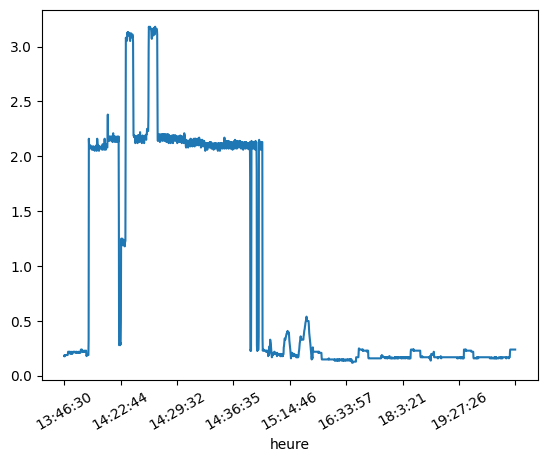

In [36]:
conso_day=conso_data[conso_data['days']==day].copy()  # no more error
conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))
#=[x.hour for x in conso_day['dates']]
df= conso_day.set_index('heure')
df.tail(2000)['kWh'].plot()
plt.xticks(rotation=30);
#conso_day['heure']


In [37]:
conso_data

,Interval,kWh,sec,Wh,cumul(ms),dates,days
0,21934,0.16,21.934,164.128750,21934,2023-08-21 21:16:35.640631,21/08/23
1,21858,0.16,21.858,164.699424,43792,2023-08-21 21:16:57.498631,21/08/23
2,22001,0.16,22.001,163.628926,65793,2023-08-21 21:17:19.499631,21/08/23
3,21928,0.16,21.928,164.173659,87721,2023-08-21 21:17:41.427631,21/08/23
4,21891,0.16,21.891,164.451144,109612,2023-08-21 21:18:03.318631,21/08/23
...,...,...,...,...,...,...,...
1946344,14977,0.24,14.977,240.368565,47691195836,2025-02-23 20:49:29.542631,23/02/25
1946345,14995,0.24,14.995,240.080027,47691210831,2025-02-23 20:49:44.537631,23/02/25
1946346,14718,0.24,14.718,244.598451,47691225549,2025-02-23 20:49:59.255631,23/02/25
1946347,14893,0.24,14.893,241.724300,47691240442,2025-02-23 20:50:14.148631,23/02/25


In [38]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
heure,,,,,,,
0:0:12,16957,0.21,16.957,212.301704,47616238569,2025-02-23 00:00:12.275631,23/02/25
0:0:28,16525,0.22,16.525,217.851740,47616255094,2025-02-23 00:00:28.800631,23/02/25
0:0:45,16649,0.22,16.649,216.229203,47616271743,2025-02-23 00:00:45.449631,23/02/25
0:1:2,16751,0.21,16.751,214.912543,47616288494,2025-02-23 00:01:02.200631,23/02/25
0:1:19,17025,0.21,17.025,211.453744,47616305519,2025-02-23 00:01:19.225631,23/02/25
...,...,...,...,...,...,...,...
20:49:29,14977,0.24,14.977,240.368565,47691195836,2025-02-23 20:49:29.542631,23/02/25
20:49:44,14995,0.24,14.995,240.080027,47691210831,2025-02-23 20:49:44.537631,23/02/25
20:49:59,14718,0.24,14.718,244.598451,47691225549,2025-02-23 20:49:59.255631,23/02/25


In [39]:
# group by hour, df  = data of a chosen day
df_byhour = df[['days','kWh']].groupby('heure', sort=False)
kwh_byhour = df_byhour['kWh']



Max : 27/01/25 4.584
Min : 31/01/25 2.817


,Interval,kWh,sec,Wh,cumul(ms),dates,days,heure
1942385,16957,0.21,16.957,212.301704,47616238569,2025-02-23 00:00:12.275631,23/02/25,0:0:12
1942386,16525,0.22,16.525,217.851740,47616255094,2025-02-23 00:00:28.800631,23/02/25,0:0:28
1942387,16649,0.22,16.649,216.229203,47616271743,2025-02-23 00:00:45.449631,23/02/25,0:0:45
1942388,16751,0.21,16.751,214.912543,47616288494,2025-02-23 00:01:02.200631,23/02/25,0:1:2
1942389,17025,0.21,17.025,211.453744,47616305519,2025-02-23 00:01:19.225631,23/02/25,0:1:19
...,...,...,...,...,...,...,...,...
1946344,14977,0.24,14.977,240.368565,47691195836,2025-02-23 20:49:29.542631,23/02/25,20:49:29
1946345,14995,0.24,14.995,240.080027,47691210831,2025-02-23 20:49:44.537631,23/02/25,20:49:44
1946346,14718,0.24,14.718,244.598451,47691225549,2025-02-23 20:49:59.255631,23/02/25,20:49:59
1946347,14893,0.24,14.893,241.724300,47691240442,2025-02-23 20:50:14.148631,23/02/25,20:50:14


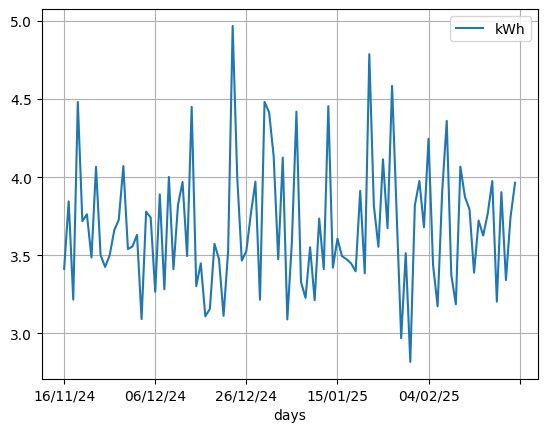

In [40]:

# premier kWh
if len(df)>1000:
    df.iloc[1000]['dates']
df.iloc[0].dates
df.dates.dt.time

# save data
df_grp.to_csv('df_grp.csv')
df.to_csv('df.csv')
df_grp.to_csv('conso_day_from_20230821.csv')

#df.info()
#df_grp.info()
df_grp.mean()
#df_grp.head()
df_grp.tail(14)
df_grp.tail(100).mean()
df_grp.tail(100).plot()
plt.grid()
# max min during last month
#print(df_grp.iloc[-31:-1])
df_grp.iloc[-31:-1].describe()

month = df_grp.iloc[-31:-1]['kWh']
print('Max :',month.idxmax(), max(month))
print('Min :',month.idxmin(), min(month))
conso_day


2025-02-23 00:00:12.275631	2025-02-23 07:57:04.329631	7h 56m 52s 	1000
2025-02-23 07:57:04.329631	2025-02-23 13:56:57.649631	5h 59m 53s 	2000
2025-02-23 13:56:57.649631	2025-02-23 15:25:47.379631	1h 28m 49s 	3000
2025-02-23 15:25:47.379631	2025-02-23 20:50:29.113631	5h 24m 41s 	964
<class 'pandas.core.frame.DataFrame'>
Index: 3964 entries, 1942385 to 1946348
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   3964 non-null   int64         
 1   kWh        3964 non-null   float64       
 2   sec        3964 non-null   float64       
 3   Wh         3964 non-null   float64       
 4   cumul(ms)  3964 non-null   int64         
 5   dates      3964 non-null   datetime64[ns]
 6   days       3964 non-null   object        
 7   heure      3964 non-null   object        
 8   hours      3964 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 309.7+ KB


('23/02/25', <Axes: xlabel='hours'>)

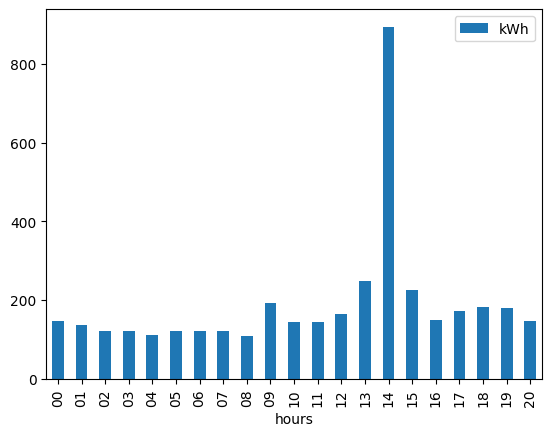

In [41]:

tranches = len(df)//1000
tranches+1
# temps de conso par tranches de 1kwh
for p in range(1,tranches+2):  # les 5 tranches de kWh consommés
    if len(df)>(p-1)*1000:
        period(p)
# conso temps réel
here = now.strftime('%H:%M:%S')
conso_jour=len(df['kWh'])
here, len(df)/1000, conso_jour
#add hours column for a chosen day
conso_hours = conso_day.copy()
conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
conso_hours.info()

conso_hours
# group conso of the day by hour
groupedbyhour = conso_hours[['hours','kWh']].groupby('hours', sort=False)
list(groupedbyhour)
day, groupedbyhour.count().plot.bar()

In [42]:
df_grp

,kWh
days,
21/08/23,0.554
22/08/23,3.701
23/08/23,4.227
24/08/23,3.686
25/08/23,3.949
...,...
19/02/25,3.203
20/02/25,3.904
21/02/25,3.341


In [43]:
# select number of days to display
span = 30
#df_grp.tail(span)


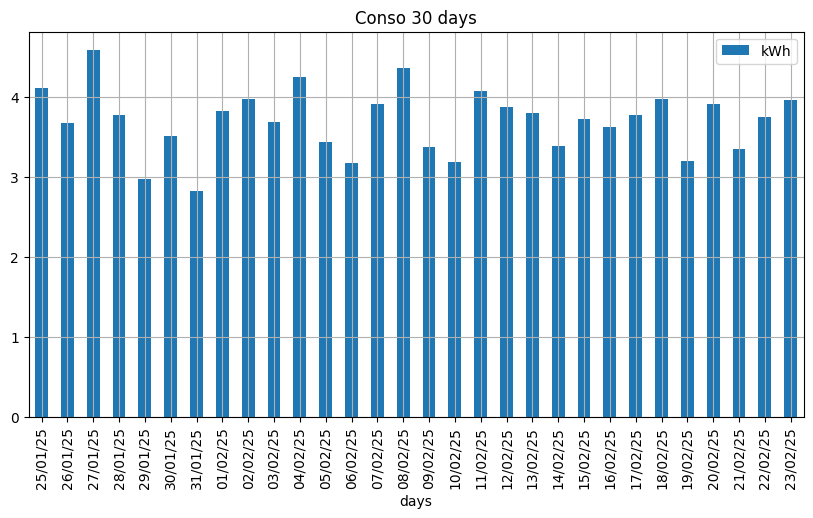

In [44]:

# Plot the figure without labels
df_grp.tail(span).plot.bar(grid=True, figsize=(10, 5), layout='tight') 
plt.title(f'Conso {span} days')
plt.xticks(rotation=90);


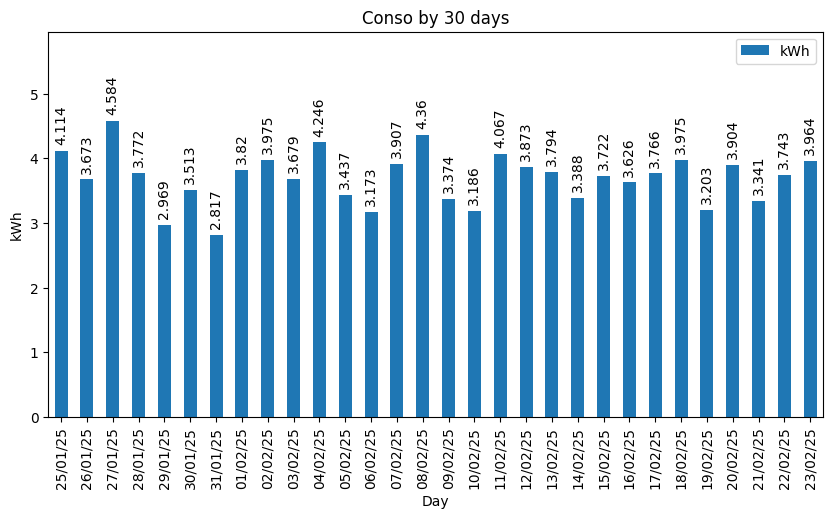

In [45]:
# Plot the figure with labels.
x_labels = list(df_grp.tail(span)['kWh'])
#x_labels
#fig, ax = plt.subplots(figsize=(2, 2), facecolor='lightskyblue',layout='constrained')
ax = df_grp.tail(span).plot(kind="bar", figsize=(10, 5), layout='tight')
ax.set_title(f"Conso by {span} days")
ax.set_xlabel("Day")
ax.set_ylabel("kWh")
ax.set_ymargin(0.3)
#ax.set_xticklabels(x_labels)
#fig.tight_layout()

rects = ax.patches

# Make some labels.
labels = [x_labels[i] for i in range(len(x_labels))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    #print(height)
    ax.text(
        rect.get_x() + rect.get_width() / 2, height+.1, label, ha="center", va="bottom", rotation=90
    )

#plt.show()

In [46]:
y_labels = df_grp.tail(span)['kWh']
y_labels

days
25/01/25    4.114
26/01/25    3.673
27/01/25    4.584
28/01/25    3.772
29/01/25    2.969
30/01/25    3.513
31/01/25    2.817
01/02/25    3.820
02/02/25    3.975
03/02/25    3.679
04/02/25    4.246
05/02/25    3.437
06/02/25    3.173
07/02/25    3.907
08/02/25    4.360
09/02/25    3.374
10/02/25    3.186
11/02/25    4.067
12/02/25    3.873
13/02/25    3.794
14/02/25    3.388
15/02/25    3.722
16/02/25    3.626
17/02/25    3.766
18/02/25    3.975
19/02/25    3.203
20/02/25    3.904
21/02/25    3.341
22/02/25    3.743
23/02/25    3.964
Name: kWh, dtype: float64

In [47]:
x_labels=df_grp.tail(span).index
x_labels

Index(['25/01/25', '26/01/25', '27/01/25', '28/01/25', '29/01/25', '30/01/25',
       '31/01/25', '01/02/25', '02/02/25', '03/02/25', '04/02/25', '05/02/25',
       '06/02/25', '07/02/25', '08/02/25', '09/02/25', '10/02/25', '11/02/25',
       '12/02/25', '13/02/25', '14/02/25', '15/02/25', '16/02/25', '17/02/25',
       '18/02/25', '19/02/25', '20/02/25', '21/02/25', '22/02/25', '23/02/25'],
      dtype='object', name='days')

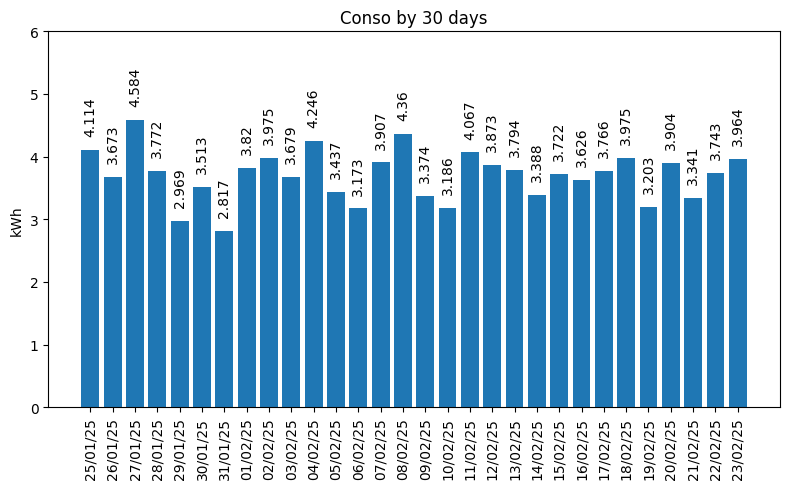

In [48]:
# Plot the figure with labels
# using bar_label
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html#sphx-glr-gallery-lines-bars-and-markers-bar-label-demo-py
fig, ax = plt.subplots(figsize=(8, 5), layout='tight')
bar_container = ax.bar(x_labels, y_labels)
#ax.set_xticks(x_labels, rotation=45)
ax.bar_label(bar_container, rotation=90, padding=10) #, fmt='{:,.0f}')
ax.set(ylabel='kWh', title=f'Conso by {span} days', ylim=(0, 6))
plt.xticks(rotation=90);


In [49]:
# figure manager

current=plt.get_current_fig_manager()
current.set_window_title('Conso by day')
#help(current.canvas)
#,facecolor='darkcyan')
#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
#plt.style.use('dark_background')


<Figure size 640x480 with 0 Axes>

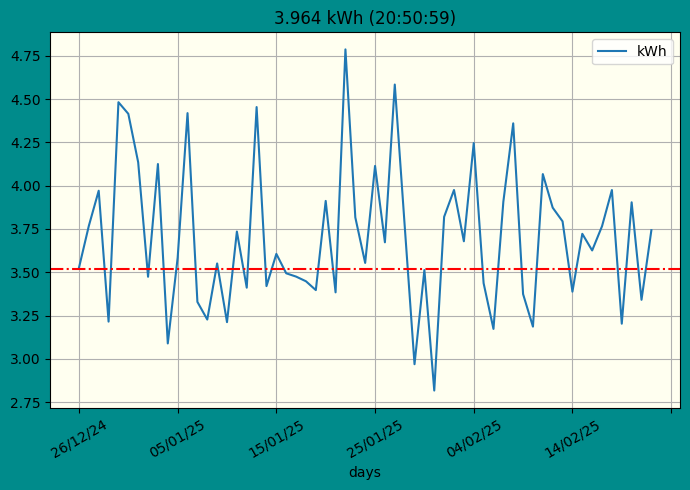

In [50]:
# pandas plot the day consos in the group
fig, ax = plt.subplots(facecolor='darkcyan', figsize=(7, 5), layout='tight')  # as argument
#or fig.patch.set_facecolor('darkcyan') # This changes the grey to white
ax.set_facecolor("ivory")

# 2 last months
df_grp.iloc[-60:-1].plot(grid=True,ax=ax, y=["kWh"])   #df.plot(x="Name", y=["Age", "Height(in cm)"], kind="bar", ax=ax)
plt.title(str(last)+' kWh ('+str(here)+')')
plt.axhline(y=np.nanmean(df_grp),c='red', ls='-.')
plt.xticks(rotation=30);  # https://ipython.readthedocs.io/en/stable/interactive/tips.html


Text(0.5, 1.0, 'Variations journalières')

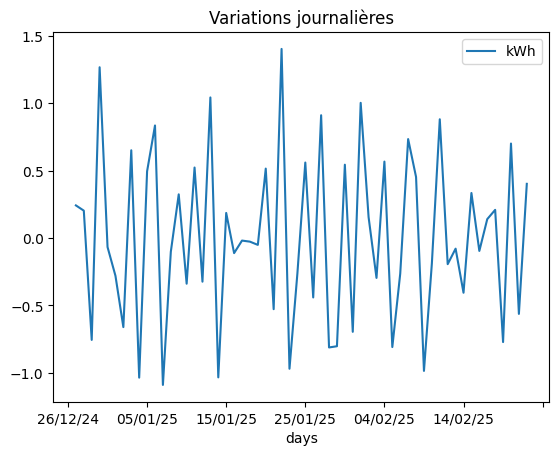

In [51]:
# variations journalières
df_grp.iloc[-60:-1].diff().plot()
plt.title('Variations journalières')

# Data from 21/08/23

In [52]:
# add hours column for conso_data (from 21/08/2023)
conso_days = conso_data.copy()
conso_days['hours']= conso_days['dates'].dt.strftime('%H')
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours
0,21934,0.16,21.934,164.128750,21934,2023-08-21 21:16:35.640631,21/08/23,21
1,21858,0.16,21.858,164.699424,43792,2023-08-21 21:16:57.498631,21/08/23,21
2,22001,0.16,22.001,163.628926,65793,2023-08-21 21:17:19.499631,21/08/23,21
3,21928,0.16,21.928,164.173659,87721,2023-08-21 21:17:41.427631,21/08/23,21
4,21891,0.16,21.891,164.451144,109612,2023-08-21 21:18:03.318631,21/08/23,21
...,...,...,...,...,...,...,...,...
1946344,14977,0.24,14.977,240.368565,47691195836,2025-02-23 20:49:29.542631,23/02/25,20
1946345,14995,0.24,14.995,240.080027,47691210831,2025-02-23 20:49:44.537631,23/02/25,20
1946346,14718,0.24,14.718,244.598451,47691225549,2025-02-23 20:49:59.255631,23/02/25,20
1946347,14893,0.24,14.893,241.724300,47691240442,2025-02-23 20:50:14.148631,23/02/25,20


In [53]:
# example groupby with apply
df = pd.DataFrame({'Animal': ['Falcon', 'Falcon',
                              'Parrot', 'Parrot'],
                   'Max Speed': [380., 370., 24., 26.]})
df.groupby("Animal", group_keys=True)[['Max Speed']].apply(lambda x: x)
      

Max Speed
Animal             
Falcon 0      380.0
       1      370.0
Parrot 2       24.0
       3       26.0

In [54]:
# import pandas as pd
# df = pd.read_csv(r'../csv/only-bh-extreme-events-satellite.csv'
#                   ,index_col=[0,1,2,3,4]
#                   ,header=[0,1,2,3]
#                   ,skipinitialspace=True
#                   #,tupleize_cols=True
#                 ) 

# df.columns = pd.MultiIndex.from_tuples(df.columns)
# df.index.names
# index=df.columns.levels[0]
# index
# df_des = pd.DataFrame(
#                             index=df.columns.levels[0],
#                             columns=['count','mean','std','min','25','50','75','max']
#                          )
# df_des

In [55]:
groupallbyday = conso_days[['days','hours','kWh']].groupby(['days'], sort=False)
groupallbyday[['kWh']].count()  #.apply(lambda x: x))

,kWh
days,
21/08/23,554
22/08/23,3701
23/08/23,4227
24/08/23,3686
25/08/23,3949
...,...
19/02/25,3203
20/02/25,3904
21/02/25,3341


In [56]:
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours
0,21934,0.16,21.934,164.128750,21934,2023-08-21 21:16:35.640631,21/08/23,21
1,21858,0.16,21.858,164.699424,43792,2023-08-21 21:16:57.498631,21/08/23,21
2,22001,0.16,22.001,163.628926,65793,2023-08-21 21:17:19.499631,21/08/23,21
3,21928,0.16,21.928,164.173659,87721,2023-08-21 21:17:41.427631,21/08/23,21
4,21891,0.16,21.891,164.451144,109612,2023-08-21 21:18:03.318631,21/08/23,21
...,...,...,...,...,...,...,...,...
1946344,14977,0.24,14.977,240.368565,47691195836,2025-02-23 20:49:29.542631,23/02/25,20
1946345,14995,0.24,14.995,240.080027,47691210831,2025-02-23 20:49:44.537631,23/02/25,20
1946346,14718,0.24,14.718,244.598451,47691225549,2025-02-23 20:49:59.255631,23/02/25,20
1946347,14893,0.24,14.893,241.724300,47691240442,2025-02-23 20:50:14.148631,23/02/25,20


In [57]:

# group all by day for all conso_days
groupallbydayhours = conso_days[['days','hours','kWh']].groupby(['days','hours'], sort=False)
# use apply to show the group
groupallbydayhours[['days','hours','kWh']].apply(lambda x: x)


days hours   kWh
days     hours                              
21/08/23 21    0        21/08/23    21  0.16
               1        21/08/23    21  0.16
               2        21/08/23    21  0.16
               3        21/08/23    21  0.16
               4        21/08/23    21  0.16
...                          ...   ...   ...
23/02/25 20    1946344  23/02/25    20  0.24
               1946345  23/02/25    20  0.24
               1946346  23/02/25    20  0.24
               1946347  23/02/25    20  0.24
               1946348  23/02/25    20  0.24

[1946349 rows x 3 columns]

In [58]:
groupallbyday.indices.keys()

dict_keys(['21/08/23', '22/08/23', '23/08/23', '24/08/23', '25/08/23', '26/08/23', '27/08/23', '28/08/23', '29/08/23', '30/08/23', '31/08/23', '01/09/23', '02/09/23', '03/09/23', '04/09/23', '05/09/23', '06/09/23', '07/09/23', '08/09/23', '09/09/23', '10/09/23', '11/09/23', '12/09/23', '13/09/23', '14/09/23', '15/09/23', '16/09/23', '17/09/23', '18/09/23', '19/09/23', '20/09/23', '21/09/23', '22/09/23', '23/09/23', '24/09/23', '25/09/23', '26/09/23', '27/09/23', '28/09/23', '29/09/23', '30/09/23', '01/10/23', '02/10/23', '03/10/23', '04/10/23', '05/10/23', '06/10/23', '07/10/23', '08/10/23', '09/10/23', '10/10/23', '11/10/23', '12/10/23', '13/10/23', '14/10/23', '15/10/23', '16/10/23', '17/10/23', '18/10/23', '19/10/23', '20/10/23', '21/10/23', '22/10/23', '23/10/23', '24/10/23', '25/10/23', '26/10/23', '27/10/23', '28/10/23', '29/10/23', '30/10/23', '31/10/23', '01/11/23', '02/11/23', '03/11/23', '04/11/23', '05/11/23', '06/11/23', '07/11/23', '08/11/23', '09/11/23', '10/11/23', '11/1

In [59]:
groupallbydayhours.indices.keys()

dict_keys([('21/08/23', '21'), ('21/08/23', '22'), ('21/08/23', '23'), ('22/08/23', '21'), ('22/08/23', '22'), ('22/08/23', '23'), ('22/08/23', '00'), ('22/08/23', '01'), ('22/08/23', '02'), ('22/08/23', '03'), ('22/08/23', '04'), ('22/08/23', '05'), ('22/08/23', '06'), ('22/08/23', '07'), ('22/08/23', '08'), ('22/08/23', '09'), ('22/08/23', '10'), ('22/08/23', '11'), ('22/08/23', '12'), ('22/08/23', '13'), ('22/08/23', '14'), ('22/08/23', '15'), ('22/08/23', '16'), ('22/08/23', '17'), ('22/08/23', '18'), ('22/08/23', '19'), ('22/08/23', '20'), ('23/08/23', '21'), ('23/08/23', '22'), ('23/08/23', '23'), ('23/08/23', '00'), ('23/08/23', '01'), ('23/08/23', '02'), ('23/08/23', '03'), ('23/08/23', '04'), ('23/08/23', '05'), ('23/08/23', '06'), ('23/08/23', '07'), ('23/08/23', '08'), ('23/08/23', '09'), ('23/08/23', '10'), ('23/08/23', '11'), ('23/08/23', '12'), ('23/08/23', '13'), ('23/08/23', '14'), ('23/08/23', '15'), ('23/08/23', '16'), ('23/08/23', '17'), ('23/08/23', '18'), ('23/08/2

In [60]:
grp_by_day = groupallbyday.count()
grp_by_day

,hours,kWh
days,,
21/08/23,554,554
22/08/23,3701,3701
23/08/23,4227,4227
24/08/23,3686,3686
25/08/23,3949,3949
...,...,...
19/02/25,3203,3203
20/02/25,3904,3904
21/02/25,3341,3341


In [61]:
grp_by_day['kWh'].cumsum()

days
21/08/23        554
22/08/23       4255
23/08/23       8482
24/08/23      12168
25/08/23      16117
             ...   
19/02/25    1931397
20/02/25    1935301
21/02/25    1938642
22/02/25    1942385
23/02/25    1946349
Name: kWh, Length: 553, dtype: int64

In [62]:
grp_by_dayhours = groupallbydayhours.count()
grp_by_dayhours

kWh
days     hours     
21/08/23 21     134
         22     282
         23     138
22/08/23 00     130
         01     130
...             ...
23/02/25 16     151
         17     173
         18     182
         19     179
         20     148

[13248 rows x 1 columns]

In [63]:
grp_by_dayhours['kWh'].cumsum()

days      hours
21/08/23  21           134
          22           416
          23           554
22/08/23  00           684
          01           814
                    ...   
23/02/25  16       1945667
          17       1945840
          18       1946022
          19       1946201
          20       1946349
Name: kWh, Length: 13248, dtype: int64

In [64]:
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(level=0)['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(level=0)['kWh'].diff()
# or
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(['days'])['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(['days'])['kWh'].diff()
grp_by_dayhours

kWh  cumsum   diff
days     hours                    
21/08/23 21     134     134    NaN
         22     282     416  148.0
         23     138     554 -144.0
22/08/23 00     130     130    NaN
         01     130     260    0.0
...             ...     ...    ...
23/02/25 16     151    3282  -75.0
         17     173    3455   22.0
         18     182    3637    9.0
         19     179    3816   -3.0
         20     148    3964  -31.0

[13248 rows x 3 columns]

In [65]:
today, grp_by_dayhours.loc[today]

('23/02/25',
        kWh  cumsum   diff
 hours                    
 00     148     148    NaN
 01     138     286  -10.0
 02     122     408  -16.0
 03     123     531    1.0
 04     111     642  -12.0
 05     121     763   10.0
 06     121     884    0.0
 07     121    1005    0.0
 08     110    1115  -11.0
 09     193    1308   83.0
 10     144    1452  -49.0
 11     144    1596    0.0
 12     165    1761   21.0
 13     250    2011   85.0
 14     894    2905  644.0
 15     226    3131 -668.0
 16     151    3282  -75.0
 17     173    3455   22.0
 18     182    3637    9.0
 19     179    3816   -3.0
 20     148    3964  -31.0)

Text(0.5, 1.0, 'Cumul journalier')

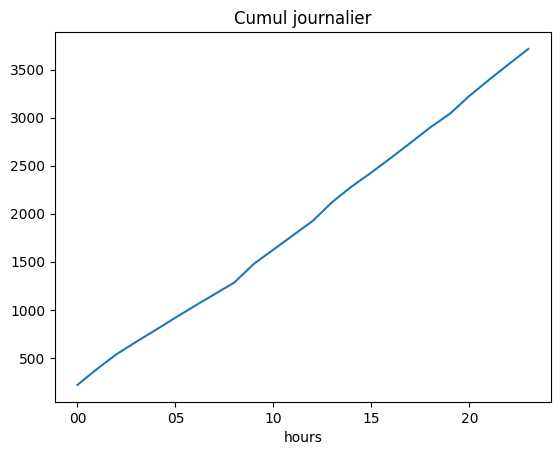

In [66]:
# progression sans surprise
grp_by_dayhours.loc['26/08/24']['cumsum'].plot()
plt.title('Cumul journalier')

Text(0.5, 1.0, 'Variation horaire')

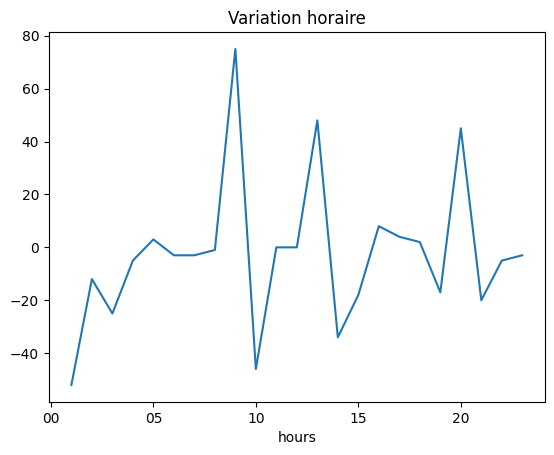

In [67]:
# plus parlant
grp_by_dayhours.loc['26/08/24']['diff'].plot()
plt.title(r'Variation horaire')

In [68]:
# count number of days since 21/08/2023
# https://stackoverflow.com/questions/45972388/count-my-multi-index-length-in-a-dataframe-pandas
n = len(grp_by_dayhours.index.levels[0].unique())
# or
n = len(grp_by_dayhours.index.levels[0])
# or
n = grp_by_dayhours.index.levshape[0]  # levshape -> (371,24)
n

553

In [69]:
df_grp.tail(n)['kWh'].describe()


count    553.000000
mean       3.519618
std        0.666141
min        0.554000
25%        3.353000
50%        3.627000
75%        3.879000
max        5.033000
Name: kWh, dtype: float64

In [70]:
maxday = df_grp.tail(n)['kWh'].idxmax()

Text(0.5, 1.0, '553 days')

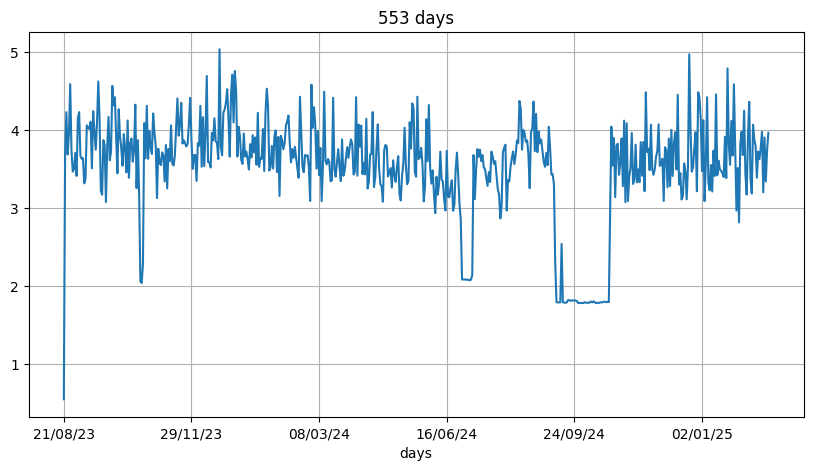

In [71]:
# show conso in span 
span = n
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.title(f'{span} days')

Text(0.5, 1.0, '400 days')

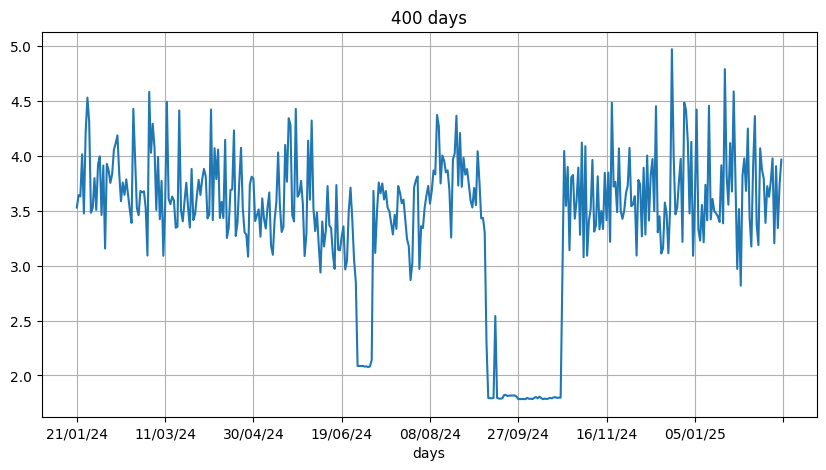

In [72]:
# show conso in span 
span = 400
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.title(f'{span} days')

In [73]:
df_grp['kWh']

days
21/08/23    0.554
22/08/23    3.701
23/08/23    4.227
24/08/23    3.686
25/08/23    3.949
            ...  
19/02/25    3.203
20/02/25    3.904
21/02/25    3.341
22/02/25    3.743
23/02/25    3.964
Name: kWh, Length: 553, dtype: float64

In [74]:
df_grp.describe()

,kWh
count,553.000000
mean,3.519618
std,0.666141
min,0.554000
25%,3.353000
50%,3.627000
75%,3.879000
max,5.033000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

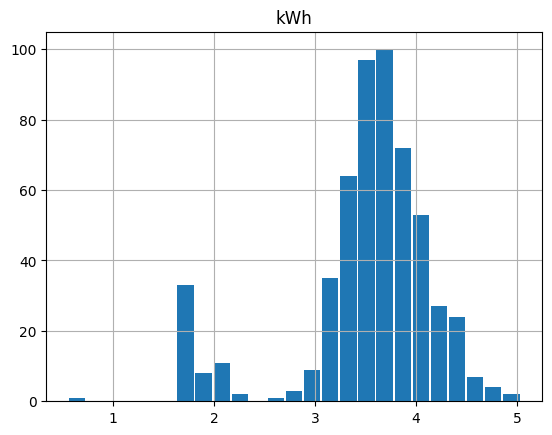

In [75]:
# répartition des consos de 1 à 5 kWh par jour
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
# histtype{'bar', 'barstacked', 'step', 'stepfilled'}, default: 'bar'
df_grp.hist(bins=25, density=False, histtype='bar',rwidth=0.9, align='mid')

In [76]:
df_grp.tail(span)['kWh']

days
21/01/24    3.528
22/01/24    3.640
23/01/24    3.629
24/01/24    4.012
25/01/24    3.474
            ...  
19/02/25    3.203
20/02/25    3.904
21/02/25    3.341
22/02/25    3.743
23/02/25    3.964
Name: kWh, Length: 400, dtype: float64

# Conso par heure

In [77]:
day

'23/02/25'

In [78]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff
hours,,,
00,148,148,NaN
01,138,286,-10.0
02,122,408,-16.0
03,123,531,1.0
04,111,642,-12.0
05,121,763,10.0
06,121,884,0.0
07,121,1005,0.0
08,110,1115,-11.0


In [79]:
# select a day to plot
day = '02/07/24'
day = today
len(grp_by_dayhours.loc[day])


21

In [80]:
l = range(1,len(grp_by_dayhours.loc[day])+1)
l

range(1, 22)

In [81]:
grp_by_dayhours.loc[day,'days'] = l #ist(1,len(grp_by_day.loc[day])+1)

In [82]:
grp_by_dayhours.loc[day,'days'].values

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21.])

In [83]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
12    13.0
13    14.0
14    15.0
15    16.0
16    17.0
17    18.0
18    19.0
19    20.0
20    21.0
Name: days, dtype: float64

In [84]:
### ????????????????????????
grp_by_dayhours.loc[day,'days'] = grp_by_dayhours.loc[day,'days'].values.astype('int64')

In [85]:
grp_by_dayhours.loc[day].info()

<class 'pandas.core.frame.DataFrame'>
Index: 21 entries, 00 to 20
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     21 non-null     int64  
 1   cumsum  21 non-null     int64  
 2   diff    20 non-null     float64
 3   days    21 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 840.0+ bytes


In [86]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
12    13.0
13    14.0
14    15.0
15    16.0
16    17.0
17    18.0
18    19.0
19    20.0
20    21.0
Name: days, dtype: float64

In [87]:
day

'23/02/25'

In [88]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff,days
hours,,,,
00,148,148,NaN,1.0
01,138,286,-10.0,2.0
02,122,408,-16.0,3.0
03,123,531,1.0,4.0
04,111,642,-12.0,5.0
05,121,763,10.0,6.0
06,121,884,0.0,7.0
07,121,1005,0.0,8.0
08,110,1115,-11.0,9.0


Text(0.5, 1.0, '23/02/25')

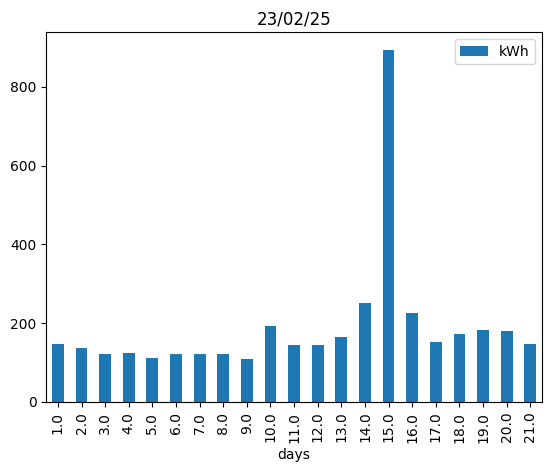

In [89]:
grp_by_dayhours.loc[day][['days','kWh']].plot.bar(x='days')
plt.title(f'{day}')

In [90]:
grp_by_dayhours.loc[day].index

Index(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20'],
      dtype='object', name='hours')

# Conso du jour


In [91]:
groupedbyhour.count()

,kWh
hours,
00,148
01,138
02,122
03,123
04,111
05,121
06,121
07,121
08,110


In [92]:
day = '09/09/24'
day = maxday
#day = today
grp_by_dayhours.loc[day].kWh

hours
00    154
01    163
02    166
03    152
04    169
05    158
06    155
07    142
08    115
09    130
10    130
11    115
12    131
13    114
14    132
15    204
16    139
17    157
18    986
19    207
20    278
21    302
22    311
23    323
Name: kWh, dtype: int64

In [93]:
def conso_by_hour(day):
    global data
    # conso by hour
    #data = groupedbyhour.count().kWh
    data = grp_by_dayhours.loc[day].kWh

    # len(groupedbyhour)
    x = np.arange(1,len(data)+1)
    ymax = max(data)+5
    #groupedbyhour.count().plot(grid=True,xticks=x)
    fig, ax = plt.subplots(figsize=(8, 5), facecolor='darkcyan')

    plt.bar(x,data)
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) {day} - Total {sum(data)}')
    plt.xlim(0,len(x)+1)
    #plt.xticks(rotation=30);
    #plt.ylim(0,ymax)

    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in data]
    fontfamily = {'calibri', 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 3, label, ha="center", va="bottom",
            fontfamily=fontfamily, fontsize=10, fontweight='bold', color='red'
        )


# 100 days

368.311

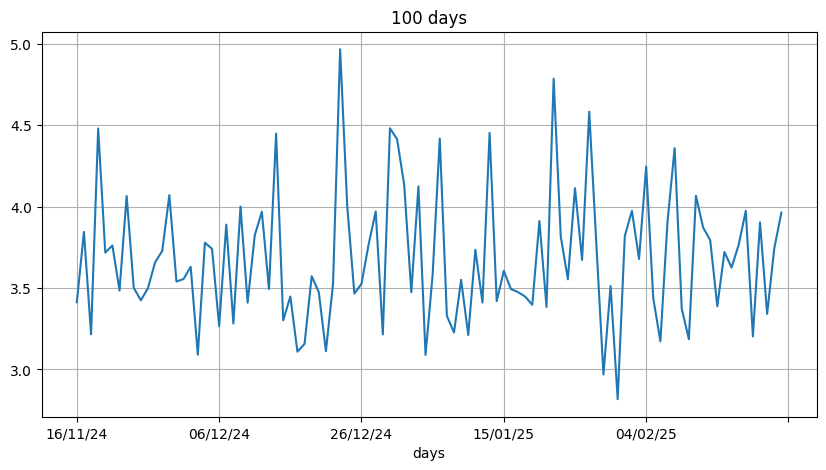

In [94]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.title(f'{span} days')
sum(df_grp.tail(span)['kWh'])

In [95]:
df_grp.tail(1)

,kWh
days,
23/02/25,3.964


In [96]:
span = 1
#df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
#plt.title(f'{span} days')
sum(df_grp.tail(span)['kWh'])

3.964

In [97]:
#import timeit
#start = timeit.timeit()
#print("hello")
end = time.time()
print(end - start)

82.16227197647095


# Today

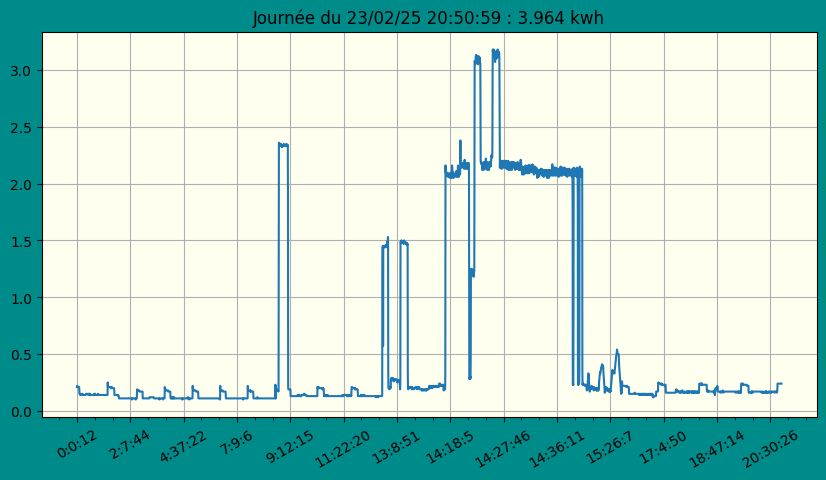

In [98]:
show(today,bgcolor='ivory')

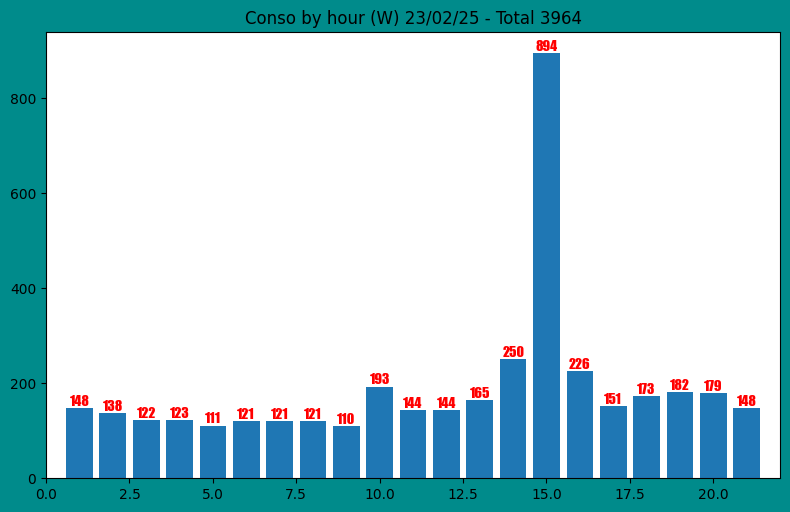

In [99]:
conso_by_hour(today)

In [100]:
day = '16/01/25'

('16/01/25', None)

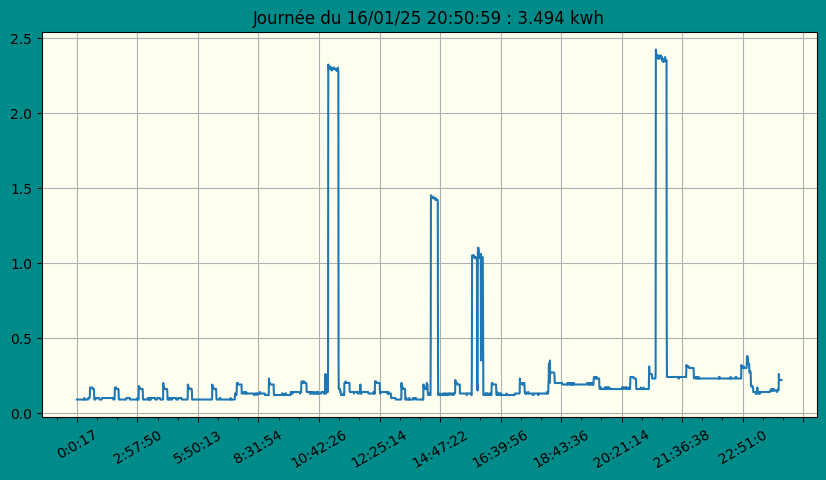

In [101]:
day, show(day,bgcolor='ivory')

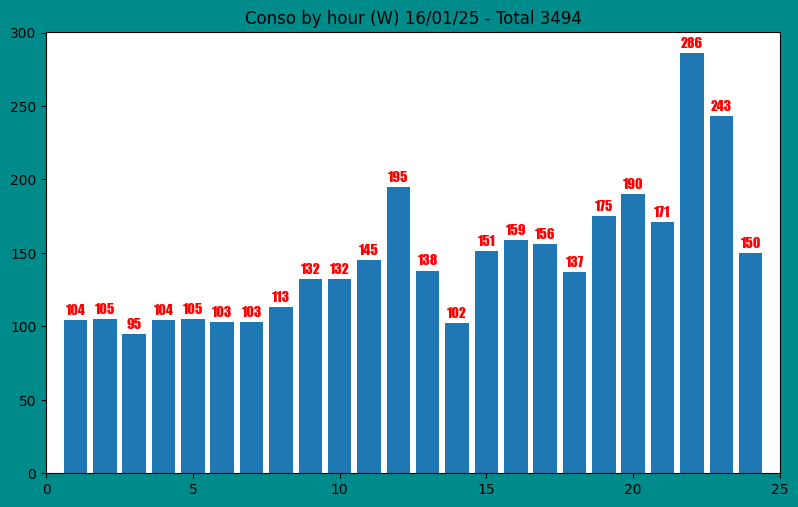

In [102]:
conso_by_hour(day)

In [103]:
maxday

'21/12/23'

('21/12/23', None)

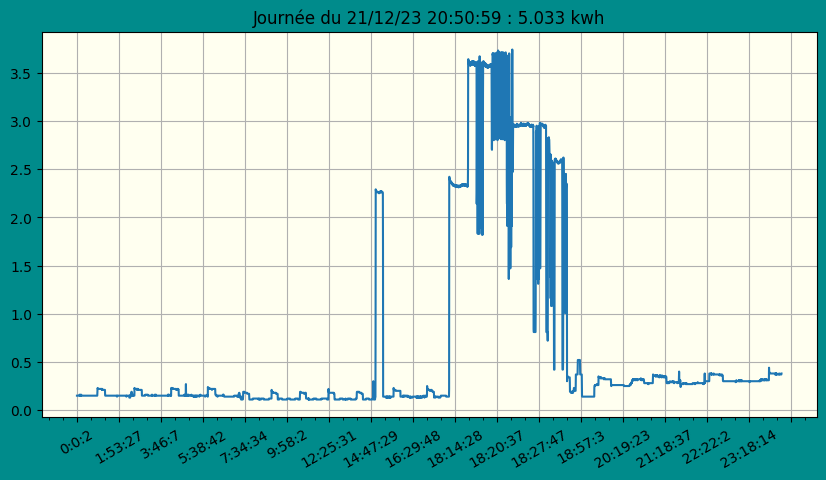

In [104]:
# retour vietnam 22/10/2024
#day = '22/10/24'
day = maxday
day, show(day,bgcolor='ivory')

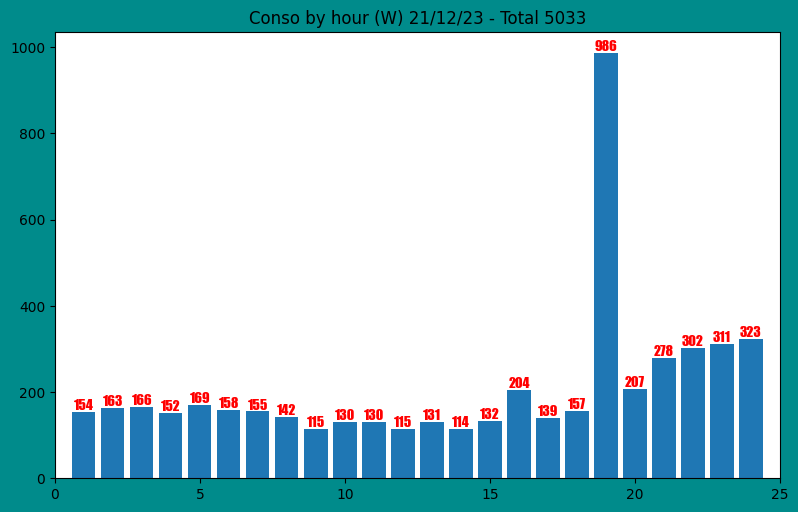

In [105]:
conso_by_hour(day)

In [106]:
sum(data)

5033

In [107]:
diff = grp_by_dayhours.loc[today]
diff


,kWh,cumsum,diff,days
hours,,,,
00,148,148,NaN,1.0
01,138,286,-10.0,2.0
02,122,408,-16.0,3.0
03,123,531,1.0,4.0
04,111,642,-12.0,5.0
05,121,763,10.0,6.0
06,121,884,0.0,7.0
07,121,1005,0.0,8.0
08,110,1115,-11.0,9.0


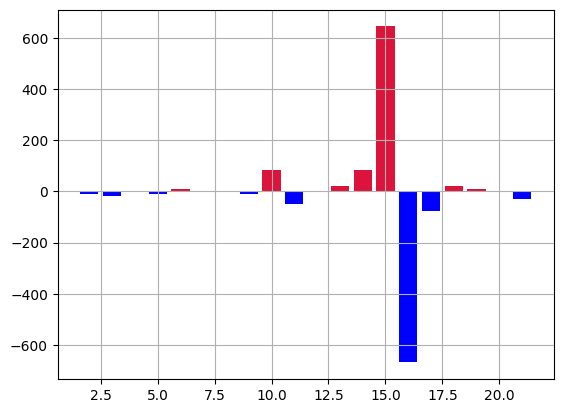

In [108]:
x = np.arange(1,len(diff)+1)

plt.bar(x,diff['diff'], color=np.where(diff['diff'] > 0, 'crimson', 'blue'))
plt.grid()

In [109]:
data

hours
00    154
01    163
02    166
03    152
04    169
05    158
06    155
07    142
08    115
09    130
10    130
11    115
12    131
13    114
14    132
15    204
16    139
17    157
18    986
19    207
20    278
21    302
22    311
23    323
Name: kWh, dtype: int64

<Axes: xlabel='hours'>

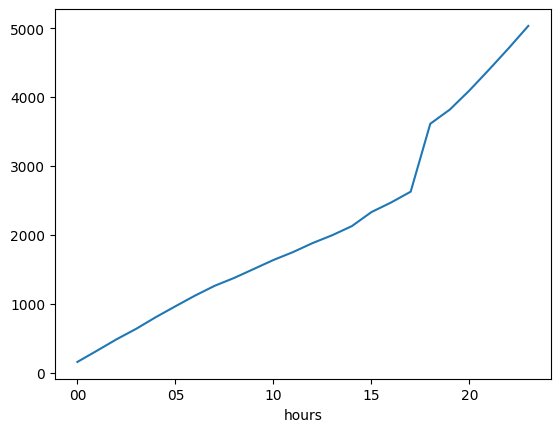

In [110]:
data.cumsum().plot()


<Axes: xlabel='hours'>

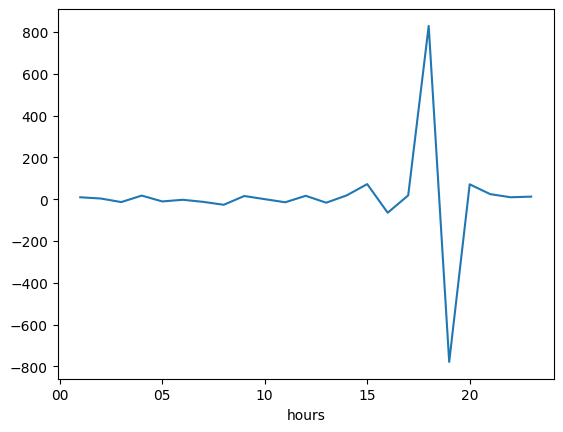

In [111]:
# evolution par heure
data.diff().plot()

In [112]:
data.diff().describe()

count     23.000000
mean       7.347826
std      244.143886
min     -779.000000
25%      -13.500000
50%        9.000000
75%       17.500000
max      829.000000
Name: kWh, dtype: float64

<Axes: >

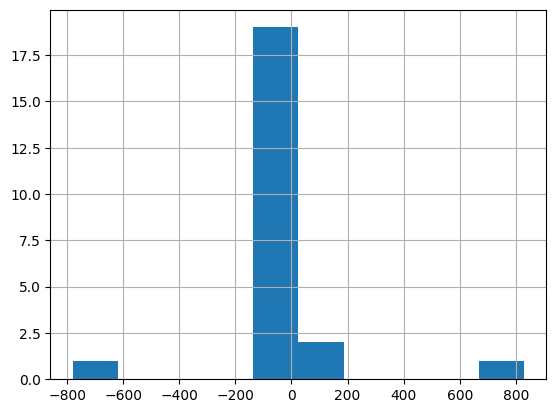

In [113]:
data.diff().hist()

# Test sauvegarde

In [114]:
import os
os.listdir(path='.')

['.git',
 '.gitignore',
 '.git_old',
 '.ipynb_checkpoints',
 '1row.flf',
 '5_days_meteo.ipynb',
 '8days.csv',
 '8days.pkl',
 '8days_dump.json',
 '8days_to_json.json',
 'advanced_expression.ipynb',
 'alphabeta_tree.ipynb',
 'amlich.ipynb',
 'amlich5.ipynb',
 'amlich5_test.ipynb',
 'amlich_data.py',
 'amlich_functions.py',
 'amlich_lib.py',
 'amlich_soc_tiet.ipynb',
 'AntPath.ipynb',
 'Apple.csv',
 'astronomie_def.ipynb',
 'atom_electronic_configuration.ipynb',
 'average_binding_energy_by_nucleons.ipynb',
 'bar_label.ipynb',
 'bell_curve.ipynb',
 'bitcoin_api.ipynb',
 'bitmap_convert.ipynb',
 'bitmap_structure.ipynb',
 'CAC40.csv',
 'chess_board.ipynb',
 'coindesk_api_client.ipynb',
 'collections.ipynb',
 'colormaps.ipynb',
 'conso.txt',
 'conso_by_hour.ipynb',
 'conso_data.csv',
 'conso_day_from_20230821.csv',
 'conso_jour.csv',
 'conso_jour.png',
 'conso_kwh.ipynb',
 'conso_kwh_reduced.ipynb',
 'conso_par_jour.csv',
 'covid19_france.ipynb',
 'cryptography_fernet.ipynb',
 'csv_readwrite

In [115]:
# list to store files
res = []
# Iterate directory
for file in os.listdir('.'):
    # check only text files
    if file.endswith('.csv'):
        res.append(file)
        print(file)
#print(res)

8days.csv
Apple.csv
CAC40.csv
conso_data.csv
conso_day_from_20230821.csv
conso_jour.csv
conso_par_jour.csv
data_temp16122022.csv
demain.csv
df.csv
df_grp.csv
DowJones.csv
EURUSD.csv
Ford.csv
karaoke.csv
ligue1_2020_27.csv
Nasdaq.csv
Nikkei.csv
planete.csv
saturn_bodies.csv
saturn_rings.csv
SMSSpamCollection.csv
table-indicateurs-open-data-dep-2023-06-30-17h59.csv
table-indicateurs-open-data-france-2023-06-30-17h59.csv
temp_humidity.csv
Tesla.csv
titanic.csv
Toyota.csv
VNDUSD.csv
WA_Fn-UseC_-Telco-Customer-Churn.csv
week.csv


In [116]:
#conso_byhour(day)

In [117]:
# save to file
import pickle
path = r'../consobyhour.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

# plot any day


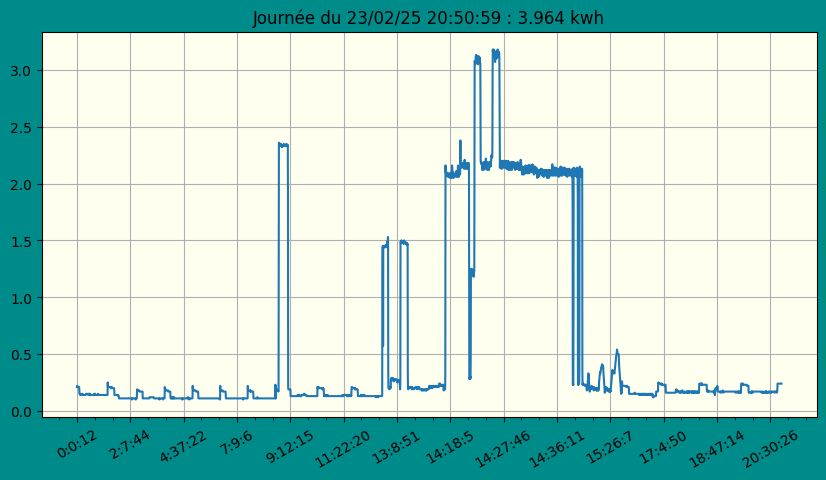

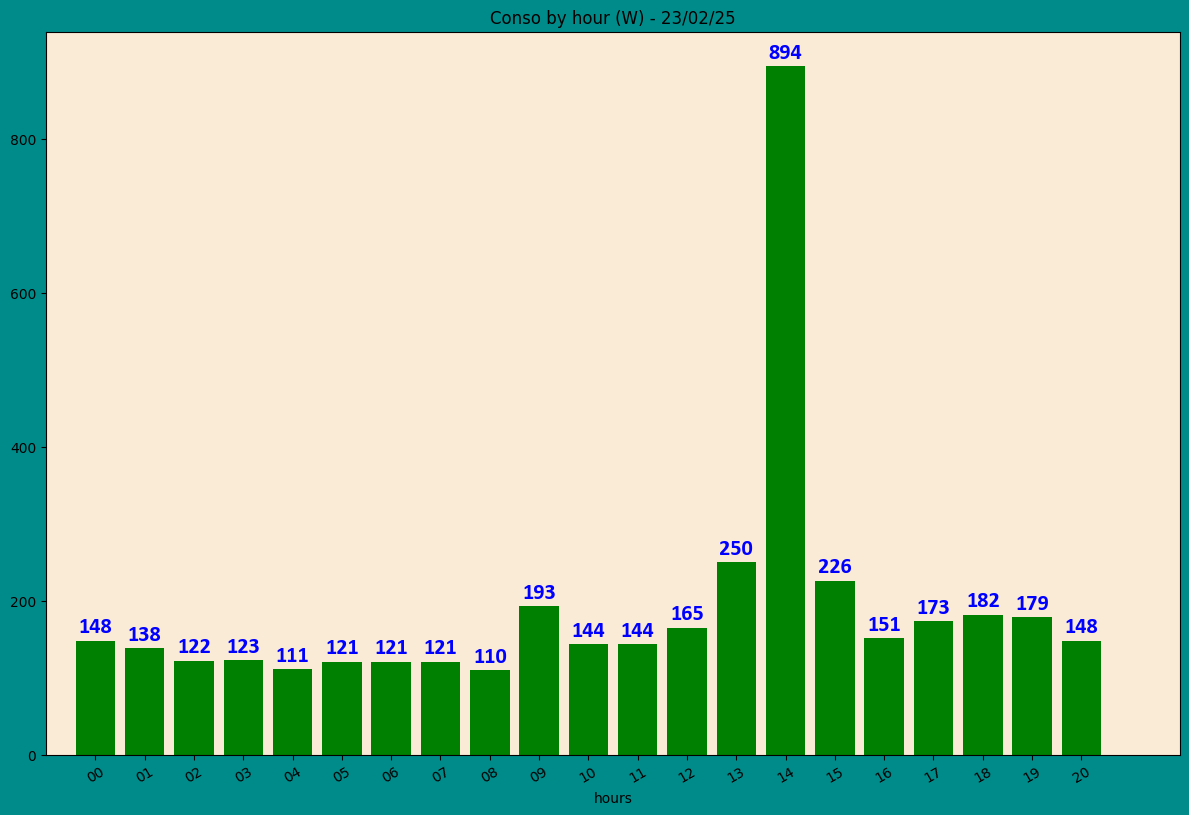

In [118]:
day = '27/10/24'
day = today
show(day,pltcolor='darkcyan')
conso_byhour(day)

In [119]:
month.describe()


count    30.000000
mean      3.685167
std       0.401849
min       2.817000
25%       3.400250
50%       3.732500
75%       3.906250
max       4.584000
Name: kWh, dtype: float64

<Axes: >

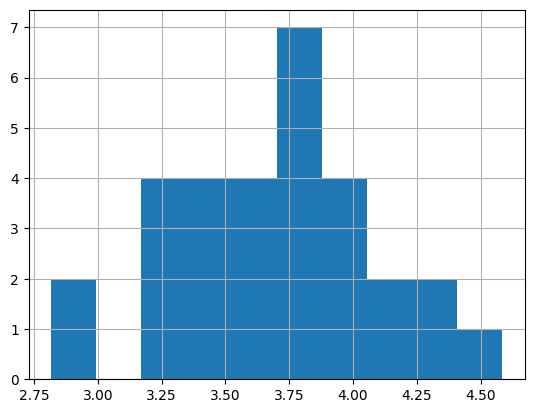

In [120]:
month.hist()

<Axes: xlabel='days'>

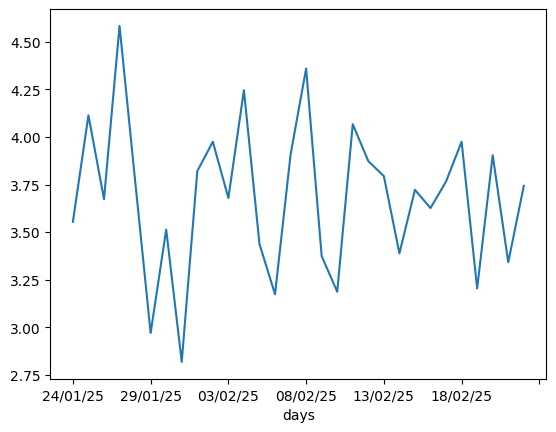

In [121]:
month.plot()

In [122]:
# date with max conso in 1 month
month.idxmax()

'27/01/25'

In [123]:
# plot month day max conso (télévision de 11h à 23h)
day = month.idxmax()
#day = '27/10/2024'
day

'27/01/25'

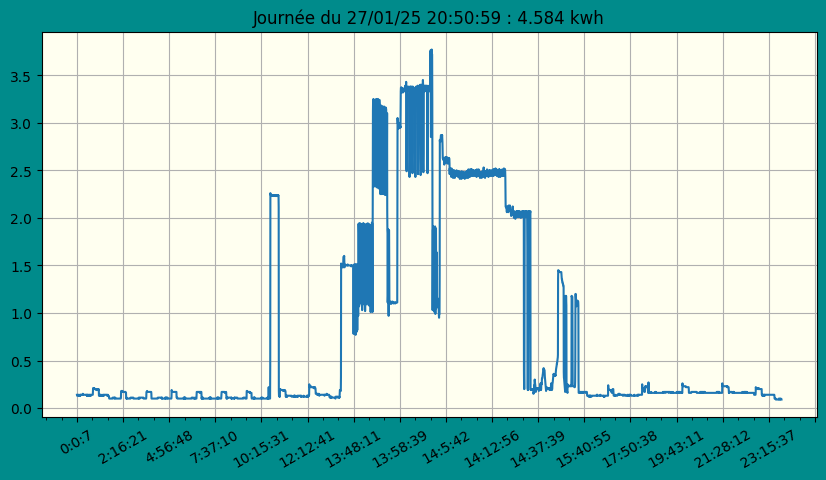

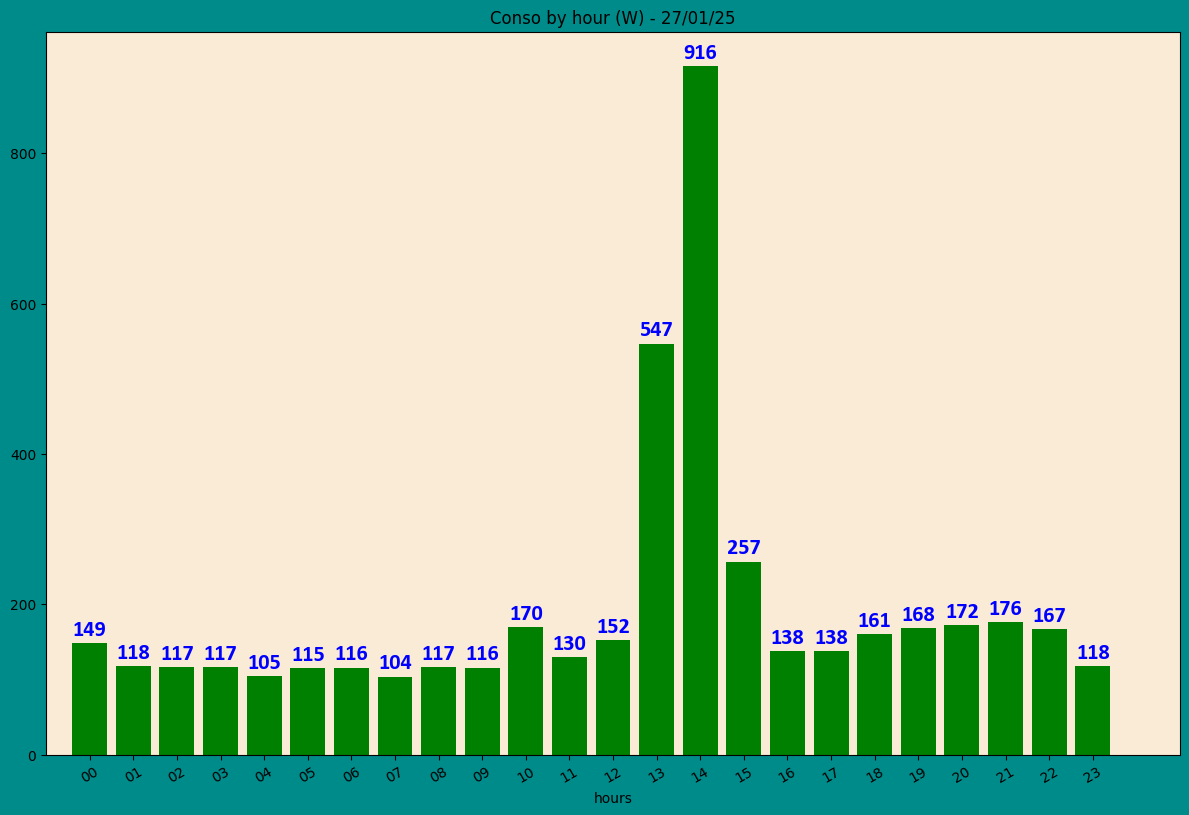

In [124]:
show(day,pltcolor='darkcyan')
conso_byhour(day)

In [125]:
grp_by_dayhours

kWh  cumsum   diff  days
days     hours                          
21/08/23 21     134     134    NaN   NaN
         22     282     416  148.0   NaN
         23     138     554 -144.0   NaN
22/08/23 00     130     130    NaN   NaN
         01     130     260    0.0   NaN
...             ...     ...    ...   ...
23/02/25 16     151    3282  -75.0  17.0
         17     173    3455   22.0  18.0
         18     182    3637    9.0  19.0
         19     179    3816   -3.0  20.0
         20     148    3964  -31.0  21.0

[13248 rows x 4 columns]

In [126]:
grp_by_dayhours.loc[month.idxmax()]

,kWh,cumsum,diff,days
hours,,,,
00,149,149,NaN,NaN
01,118,267,-31.0,NaN
02,117,384,-1.0,NaN
03,117,501,0.0,NaN
04,105,606,-12.0,NaN
05,115,721,10.0,NaN
06,116,837,1.0,NaN
07,104,941,-12.0,NaN
08,117,1058,13.0,NaN


In [127]:
grp_by_dayhours.columns

Index(['kWh', 'cumsum', 'diff', 'days'], dtype='object')

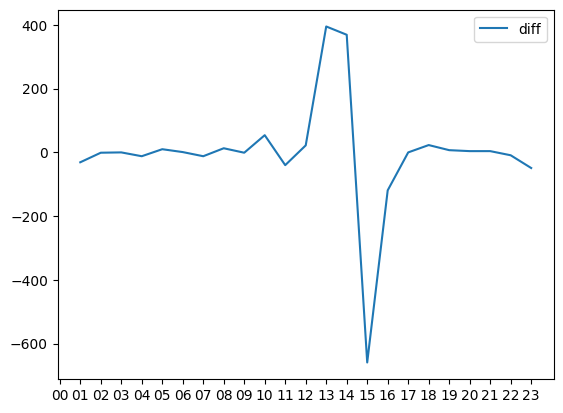

In [128]:
# diff
plt.plot(grp_by_dayhours.loc[month.idxmax()]['diff'],label=grp_by_dayhours.columns[2])
plt.legend()

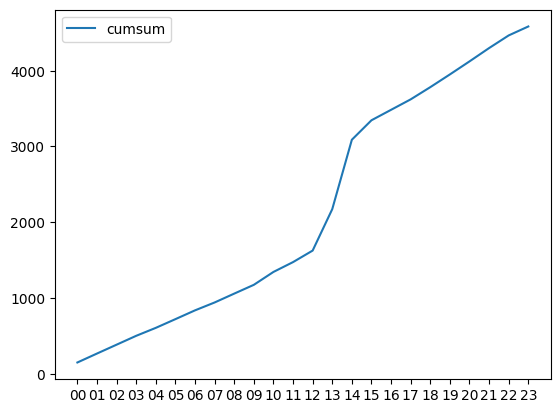

In [129]:
# cumsum
plt.plot(grp_by_dayhours.loc[month.idxmax()]['cumsum'],label=grp_by_dayhours.columns[1])
plt.legend()

In [130]:
# 41 s
# file to big to git sync

# create .gitignore
filename=r'../conso_data.csv'
#conso_data.to_csv(filename)
#43.6s size 140128 kB